In [1]:
#Importing libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten 
from tensorflow.keras.models import Model

from sklearn.metrics import precision_recall_fscore_support, classification_report

In [2]:
#loading the dataset
#taking only 1000 images for faster training
train_labels= pd.read_csv("cars/labels_train.csv")
train_labels=train_labels[:1000]
val_labels=pd.read_csv("cars/labels_trainval.csv")
val_labels=val_labels[:1000]


In [3]:
train_labels.head()

,frame,xmin,xmax,ymin,ymax,class_id
0,1478019952686311006.jpg,237,251,143,155,1
1,1478019952686311006.jpg,437,454,120,186,3
2,1478019953180167674.jpg,218,231,146,158,1
3,1478019953689774621.jpg,171,182,141,154,2
4,1478019953689774621.jpg,179,191,144,155,1


In [4]:
val_labels.head()

,frame,xmin,xmax,ymin,ymax,class_id
0,1478019952686311006.jpg,237,251,143,155,1
1,1478019952686311006.jpg,437,454,120,186,3
2,1478019953180167674.jpg,218,231,146,158,1
3,1478019953689774621.jpg,171,182,141,154,2
4,1478019953689774621.jpg,179,191,144,155,1


In [5]:
#Checking the number of rows and columns
train_labels.shape,val_labels.shape

((1000, 6), (1000, 6))

Since restnet expects the input size of the image as 224x224 imagesize, we preprocess the data

In [6]:
train_labels[['xmin','xmax']]/=224

In [7]:
train_labels[["ymin","ymax"]]/=224

In [8]:
train_labels.head()

,frame,xmin,xmax,ymin,ymax,class_id
0,1478019952686311006.jpg,1.058036,1.120536,0.638393,0.691964,1
1,1478019952686311006.jpg,1.950893,2.026786,0.535714,0.830357,3
2,1478019953180167674.jpg,0.973214,1.031250,0.651786,0.705357,1
3,1478019953689774621.jpg,0.763393,0.812500,0.629464,0.687500,2
4,1478019953689774621.jpg,0.799107,0.852679,0.642857,0.691964,1


In [9]:
val_labels[['xmin','xmax']]/=224

In [10]:
val_labels[['ymin','ymax']]/=224

In [11]:
val_labels.head()

,frame,xmin,xmax,ymin,ymax,class_id
0,1478019952686311006.jpg,1.058036,1.120536,0.638393,0.691964,1
1,1478019952686311006.jpg,1.950893,2.026786,0.535714,0.830357,3
2,1478019953180167674.jpg,0.973214,1.031250,0.651786,0.705357,1
3,1478019953689774621.jpg,0.763393,0.812500,0.629464,0.687500,2
4,1478019953689774621.jpg,0.799107,0.852679,0.642857,0.691964,1


For splitting training data into train and test

In [12]:
train_data, test_data=train_test_split(train_labels,test_size=0.2,random_state=42)

For data augmentation

In [13]:
augmentor= ImageDataGenerator(rotation_range=20,shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode="nearest", width_shift_range=0.2, height_shift_range=0.2)

Preparing training data

In [14]:
images=[]
labels=[]
for i,row in train_data.iterrows():
    image_path=f"cars/images/{row['frame']}"
    img=load_img(image_path, target_size=(224,224))
    img=img_to_array(img)
    img=augmentor.random_transform(img)
    images.append(img)
    labels.append([row['xmin'],row['xmax'],row['ymin'],row['ymax'],row['class_id']])

In [15]:
images=np.array(images)

In [16]:
labels=np.array(labels)

In [17]:
test_images=[]
test_labels=[]

for i, row in test_data.iterrows():
    image_path=f"cars/images/{row['frame']}"
    img=load_img(image_path,target_size=(224,224))
    img=img_to_array(img)
    test_images.append(img)
    test_labels.append([row['xmin'],row['xmax'],row['ymin'],row['ymax'],row['class_id']])

    

In [18]:
test_images=np.array(test_images)
test_labels=np.array(test_labels)

In [19]:
#creating a base model using ResNet
#include_top=False because we are not importing output layers like dense and flatten
base_model=ResNet50(weights="imagenet",include_top=False, input_shape=(224,224,3))
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

In [20]:
#extracting the feature map of the base model.
x=base_model.output
x=Flatten()(x)
x=Dense(1024,activation="relu")(x)
x=Dense(512,activation="relu")(x)
#5 final memory neurons because 4 for bounding box coordinates and one for class label.
output=Dense(5,activation="linear")(x)

In [21]:
model=Model(inputs=base_model.input,outputs=output)

In [22]:
model.compile(optimizer="adam",loss="mean_squared_error",metrics=['accuracy'])

In [23]:
#model.summary()

Training the model for 10 epochs

In [24]:
history=model.fit(images,labels,batch_size=8,epochs=20,validation_data=(test_images,test_labels))

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.3250 - loss: 1325.1506 - val_accuracy: 0.0050 - val_loss: 22.1711
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.2195 - loss: 27.1520 - val_accuracy: 0.8400 - val_loss: 8.8099
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.4055 - loss: 7.9170 - val_accuracy: 0.8450 - val_loss: 7.0327
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.5723 - loss: 2.7767 - val_accuracy: 0.7700 - val_loss: 3.0561
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.6122 - loss: 1.4068 - val_accuracy: 0.8000 - val_loss: 1.0524
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.7099 - loss: 0.6714 - val_accuracy: 0.8050 - val_loss: 0.9893
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.6779 - loss: 0.5233 - val_accuracy: 0.7200 - val_loss: 1.4588
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.6649 - loss: 0.3499 - val

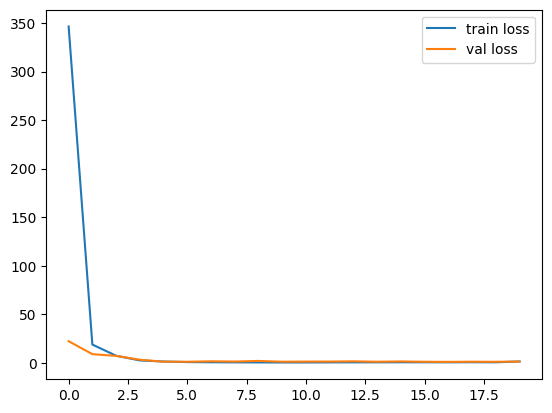

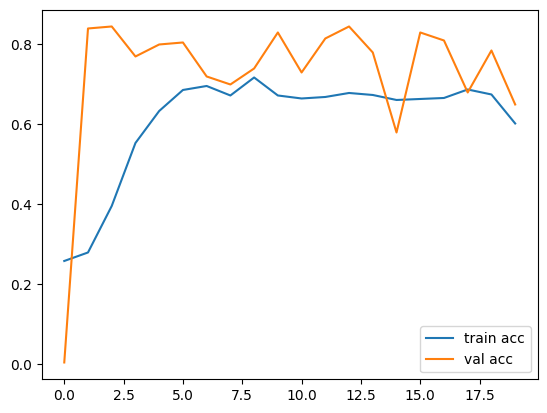

<Figure size 640x480 with 0 Axes>

In [25]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [26]:
#Evaluating the model

model.evaluate(test_images, test_labels)

7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.6777 - loss: 1.2470


[1.2194340229034424, 0.6499999761581421]

In [31]:
model.save("Car_detection.h5")

In [30]:
model.save("Car_detectionmodel_keras.keras")

In [33]:
prediction=model.predict(test_images)

7/7 ━━━━━━━━━━━━━━━━━━━━ 43s 7s/step


In [34]:
prediction

array([[ 0.697935  ,  1.0444497 ,  1.5023841 ,  0.51901305,  2.484561  ],
       [ 1.8986763 ,  0.74441946,  1.4913987 ,  0.6403643 ,  2.995637  ],
       [ 1.8986763 ,  0.74441946,  1.4913987 ,  0.6403643 ,  2.995637  ],
       [ 1.3837415 ,  1.0864061 ,  1.7953118 ,  0.3260704 ,  2.1728172 ],
       [ 0.9086174 ,  0.46694124,  1.97503   ,  0.4927412 ,  2.3484755 ],
       [ 1.2863334 ,  1.3584474 ,  1.964779  ,  0.45690593,  1.8264359 ],
       [ 1.8388072 ,  1.3757404 ,  1.9105531 ,  0.16156922,  4.0039454 ],
       [ 0.697935  ,  1.0444497 ,  1.5023841 ,  0.51901305,  2.484561  ],
       [ 0.9238781 ,  0.55992734,  2.083136  ,  0.48804244,  1.4973992 ],
       [ 1.0086097 , -0.10533773,  1.8921144 ,  0.43121108,  2.3103533 ],
       [ 1.7157315 ,  1.5425557 ,  1.6469204 ,  0.4616743 ,  4.157073  ],
       [ 0.88728607,  0.5252007 ,  1.8891991 ,  0.32553348,  1.0923089 ],
       [ 1.1576685 ,  1.0554699 ,  2.180095  ,  0.46896324,  2.760087  ],
       [ 1.3580354 ,  0.4357103 ,  2.0

In [36]:
y_true=test_labels[:,4].flatten()

In [37]:
y_pred=prediction[:,4].flatten()

In [38]:
y_true

array([5., 5., 1., 1., 5., 1., 5., 1., 5., 1., 5., 3., 5., 5., 1., 1., 5.,
       1., 5., 1., 5., 1., 1., 1., 1., 5., 1., 1., 1., 1., 1., 1., 5., 5.,
       1., 1., 3., 5., 1., 1., 1., 3., 1., 5., 5., 1., 1., 5., 1., 5., 5.,
       2., 5., 1., 1., 1., 5., 1., 1., 1., 5., 1., 1., 5., 5., 1., 3., 1.,
       1., 5., 3., 5., 1., 1., 3., 5., 1., 1., 1., 5., 1., 1., 5., 1., 1.,
       5., 1., 1., 1., 1., 1., 5., 5., 1., 5., 5., 1., 3., 3., 5., 1., 1.,
       1., 4., 5., 1., 1., 5., 1., 2., 1., 1., 1., 1., 1., 1., 5., 5., 5.,
       5., 5., 1., 1., 1., 1., 5., 5., 5., 1., 5., 5., 1., 1., 1., 1., 1.,
       1., 5., 2., 1., 2., 5., 5., 5., 5., 5., 1., 1., 1., 5., 1., 5., 5.,
       5., 5., 1., 5., 1., 1., 1., 1., 1., 3., 1., 1., 1., 5., 1., 5., 1.,
       1., 5., 5., 5., 1., 1., 1., 5., 5., 3., 5., 1., 5., 1., 2., 5., 1.,
       1., 1., 5., 1., 5., 3., 1., 1., 1., 3., 5., 5., 1.])

In [39]:
y_pred

array([2.484561  , 2.995637  , 2.995637  , 2.1728172 , 2.3484755 ,
       1.8264359 , 4.0039454 , 2.484561  , 1.4973992 , 2.3103533 ,
       4.157073  , 1.0923089 , 2.760087  , 1.4573392 , 3.8275251 ,
       3.0472307 , 2.573182  , 2.472146  , 2.2881594 , 2.7672987 ,
       3.3454504 , 5.165942  , 2.1989183 , 2.9833574 , 2.18219   ,
       2.207528  , 1.56083   , 2.6055555 , 3.0472307 , 3.7648535 ,
       3.1529217 , 2.7929506 , 3.1647615 , 3.092949  , 1.2973679 ,
       2.9181318 , 2.7221193 , 3.3986273 , 3.0472307 , 0.535407  ,
       2.452649  , 1.1583565 , 2.539075  , 1.4573392 , 1.4058446 ,
       2.573182  , 2.4992056 , 2.7773275 , 2.6938066 , 3.4061642 ,
       2.8763952 , 2.472146  , 2.6985388 , 3.3986273 , 1.5479821 ,
       1.7279519 , 3.1647615 , 1.2097138 , 2.207528  , 3.1036654 ,
       1.4058446 , 1.3507394 , 3.3454504 , 2.18219   , 2.5770388 ,
       2.4679022 , 2.1728172 , 1.4365567 , 0.5168504 , 3.3454504 ,
       0.8687162 , 3.6985054 , 2.7143202 , 2.995637  , 2.57318

In [40]:
len(y_true)

200

In [41]:
len(y_pred)

200

In [44]:
y_pred=np.ceil(y_pred)

In [45]:
precision,recall,f1,support=precision_recall_fscore_support(y_true,y_pred,average='weighted')

/Applications/selfdrivingcar/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [46]:
precision

0.5942851906158357

In [47]:
recall

0.1

In [48]:
f1

0.12473021403683424